# AutoAnno

<a id='toc'></a>

## Table of contents

## [1. Proposal](#proposal)
## [2. Data Description](#data)
## [3. Data Cleaning](#cleaning)
## [4. Feature Engineering](#features)

<a id='proposal'></a>

# Proposal

[**Return to table of contents** ](#toc) 

A project that searches for a business solution to the automated annotation of big data.

## Why?

As a networking exercise I have interviewed around 40 or so data scientists and quantitative finance analysts. Natural Language Processing
seems to be immensely popular in the current meta of data science. In all of the conversations, the one constant is the acceptance
of annotation of text based data being a "necessary evil"; for supervised learning and modeling accurate labels are required. 

There are many companies dedicated to using ML and human resources to annotate data; therefore, doing this accurately and
efficiently than humans can do on their own is a great business opportunity.

In my opinion this investigation is bounded only by creativity; the following are some preliminary ideas. 

    1. Topological Data Analysis applied to embeddings of text data.
    2. Convolutional neural networks applied to text data converted into images.
    3. Using graph neural networks or just network graphs to better capture the context of the text data
   
## First attempt

The first trial method is going to use topological data analysis to hopefully detect clusters in embedding text data,
each cluster corresponding to an annotation label. Topological data analysis comes in a variety of flavors.
The avenues I will investigate are the ToMATo algorithm and using a Vietoris-Rips complex on the embedding data.

What does this jargon mean? Vietoris-rips, crudely speaking, is a name for an algorithm.
This algorithm detects structures (topologically, holes) by a filtration method. 

This method centers an imaginary sphere at each data point. The radius of these spheres is uniformly increased (they are identical in size);
whenever two spheres overlap, a simplex (line segment) is drawn connecting the centers (each data point). When three spheres overlap,
the 2-simplex (triangle) that is defined by the three connecting line segments is "filled in", this pattern continues for more overlaps
resulting in tetrahedrons, etc. See the image below for a 2-d example.

![Rips complex](./rips.png)

Clearly, as the radius of the spheres becomes as large as the "diameter" of the data points, all points are connected. 
The useful information comes from tracking the "birth" and "death" of the different shapes. "birth" and "death" correspond
to creation of new simplicies (i.e. when spheres overlap), "death" corresponds to the merging of disjoint pieces; when they are connected
by a new simplex. The births and deaths of simplicies of different dimension are tracked; the longer lived the components are, the
more indicative they are of structure. 

# Preliminary project statement

## First stage : topic annotation

Breaking down each conversation into its smallest annotated components is the end goal, however this amounts to trying
to detect small clusters; first, let's see if topic can be annotated. Towards this end, there are 6 `json` files, one for each topic:

- flights.json
- food-ordering.json
- hotels.json
- movies.json
- music.json
- restaurant-search.json
- sports.json


The first step is to get the data into a format that is compatible with various word embedding algorithms

<a id='data'></a>

# Data preview

[**Return to table of contents** ](#toc) 

This notebook is dedicated to cleaning and exploring data from the Taskmaster dataset, namely, its second component `TM-2-2020`
First, let us look at the README so we can figure out the best way to import it. 

### Original Taskmaster README

**NUMBERS**
The Taskmaster-2 dataset consists of 17,289 dialogs in the seven domains below. Dialogs for each domain can be found in the seven json files located in this directory's "data" folder, i.e. Taskmaster/TM-2-2-20/data/.
* restaurants (3276)
* food ordering (1050)
* movies (3047)
* hotels (2355)
* flights (2481)
* music (1602)
* sports (3478)

**STRUCTURE**
Each conversation in the data file has the following structure:
* __conversation_id:__ A universally unique identifier with the prefix 'dlg-'. The ID has no meaning.
* __utterances:__ An array of utterances that make up the conversation.
* __instruction_id:__ A reference to the file(s) containing the user (and, if applicable, agent) instructions for this conversation.

Each utterance has the following fields:
* __index:__ A 0-based index indicating the order of the utterances in the conversation.
* __speaker:__ Either USER or ASSISTANT, indicating which role generated this utterance.
* __text:__ The raw text of the utterance. 'ASSISTANT' turns are originally written (then played to the user via TTS) and 'USER' turns are transcribed from the spoken recordings of crowdsourced workers.
* __segments:__ An array of various text spans with semantic annotations.

Each segment has the following fields:
* __start_index:__ The position of the start of the annotation in the utterance text.
* __end_index:__ The position of the end of the annotation in the utterance text.
* __text:__ The raw text that has been annotated.
* __annotations:__ An array of annotation details for this segment.

Each annotation has a single field:
* __name:__ The annotation name.

## Data Summary

The text-based data is split between files, in a nested dict structure, the highest level contains tags by ID, and topic instructions.
The next level are conversations, which contain the sentences or "utterances" as separate dicts. For each utterance there is another
dictionary of "segments" which is everything in the annotation except the label. If an utterance is not annotized then this may be empty. 
If the annotation segments exist, then they are included as a dict with starting and stopping positions, w.r.t. string elements, the
raw text, and the annotation label; this is included as another dict but it only consists of a key "name" and the label; and so is currently redundant
for my purposes. 

I simply want the raw text data, in a format that permits exploration and modeling, and so I will either put each sentence in a list wherein the
elements are words, or lists of conversations, where elements are words but the list contains the entire paragraph. As I am treating this
as an unsupervised learning project, the annotation data is only used for evaluation, NOT training.

In [1]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import glob
import os
import re

In other words, we have nested dictionaries. Building up from the lower level, let's look at different samples of keys.

In [2]:
documents = {}
# get the .json filenames
for jsfiles in glob.glob('./Taskmaster/TM-2-2020/data/*.json'):
    with open(jsfiles, 'r') as f:
        # import as a list of nested dicts.
        contents = json.load(f)
        # for reference by label use a dict.
        documents[os.path.basename(jsfiles).split('.')[0]] = contents

The original document labels the conversations by ID and by the instructions they are based off of. Only need the text
for now; extract the relevant data from this dictionary level.

In [3]:
# For now, tagging by conversation ID / 
all_topics =[[each_conversation['utterances'] for each_conversation in data]
                          for each_topic, data in documents.items()]
flight_conversations = all_topics[0]

Each conversation is comprised of a sequence of utterances. Let's look at a conversation line by line to get an idea
as to the state of the data.

In [4]:
for i, line in enumerate(flight_conversations[0]):
    print(f"{str(i)}: {line['text']}")

0: Hello. I'd like to find a round trip commercial airline flight from San Francisco to Denver.
1: Hello, how can I help you?
2: San Francisco to Denver, got it.
3: You're really on top of things. I like that.
4: So what days are you looking to fly?
5: Hey, what else can you say?
6: I'm looking to fly out sometime today, the earliest time today, and I'll be returning in 4 days.
7: So, I would like to fly out sometime tonight and fly back in the evening in 4 days. From I'm looking to go to Denver. I'm flying out of San Francisco.
8: That sounds good, where you looking to go?
9: That's right okay we have prices starting at $337.
10: That sounds very good. I just have two preferences. I want a nonstop flight.
11: And I'd like to get an aisle seat.
12: Okay, Non-Stop and if I heard you correctly did you say you wanted to leave as early as possible and also Nile C.
13: Yes.
14: Okay, you got it so it looks like United Airlines leaves at 9:20 p.m. that is nonstop the flight duration is 2 hou

While currently not going to be used, let's get an idea as to how specific the labels are, for future awareness

In [5]:
label_set = set()
label_val = set()
for utterances_list in flight_conversations:
    for utterances in utterances_list:
        for segments in utterances.get('segments', ()):
            for anno in segments['annotations']:
                if isinstance(anno, dict):
                    for name, target_label in anno.items():
                        label_set.add(name)
                        label_val.add(target_label)
print(f"The unique keys in the annotation dict are: {chr(10)}{label_set}{chr(10)}")
print(f"A subset of unique values in the annotation dict are: {chr(10)+chr(10)}{chr(10).join(list(label_val)[:10])}")

The unique keys in the annotation dict are: 
{'name'}

A subset of unique values in the annotation dict are: 

flight_search.seat_location
flight3_detail.seating_class
flight4_detail.from
flight2_detail.stops
flight_search.total_fare
flight4_detail.stops.location
flight_search.destination1
flight4_detail.airline
flight3_detail.from.time
flight4_detail.fare


<a id='cleaning'></a>

# Data Cleaning and Wrangling.

[**Return to table of contents** ](#toc) 

There are a number of important cleaning steps in order to get the text-based data ready for embedding,
I will describe the transformations in detail next. As a manner of convention; the methods and functions
sometimes introduce seemingly errant whitespace, however, it is much easier to insert whitespace and remove it later
than try to guess where strings have been unduely concatenated. Any and all mappings use this liberally until
the last mapping, which, as you may have guessed, shrinks all remaining white spaces to single instances.

#### Example conversation

First, print out line by line one of the conversations.

#### 1. Numbers

I want to replace numeric digits with their english based representations. While infrequent, I think numbers can be quite important in establishing context. for example, scores of sports games seem to be transcribed #-#. Times for flights, #:##, and so on. However, as can be seen in these two examples, they are often utilized in conjunction with other symbols, which will still be replaced due to a lack of convention between conversations.

To convert from numeric to word representations of the numbers, use the package ``inflect``

In [6]:
import inflect

p = inflect.engine()
n2wfunc = p.number_to_words

In [7]:
def num_to_word_wrapper(val):
    if isinstance(val, str) and (ord(val)>= 48) and (ord(val) <= 57):
        buffer = ' '
        return buffer + p.number_to_words(val) + buffer
    else:
        return val

In [8]:
corpus_text = []
for each_topic in all_topics:
    conversation_corpus = []
    for each_conversation in each_topic:
        utterance_corpus = []
        for each_utterance in each_conversation:
            utterance_corpus.append(''.join(list(map(num_to_word_wrapper, each_utterance['text']))))
        conversation_corpus.append(utterance_corpus)
    corpus_text.append(conversation_corpus)

In [9]:
utterance_corpus

['How can I help you?',
 'I was wondering, could you tell me how Real Salt Lake is doing in the standings?',
 'This will just be in a second, please wait.',
 'Okay.',
 'Real Salt Lake is currently in  eight th Place in the Western Conference. They are  one  zero  games back from FC Dallas.',
 'Okay. Did they play today?',
 'Please wait for a second.',
 'No, they do not play today. They do play tomorrow at  five  p.m against Columbus.',
 'Okay, did they play last Saturday?',
 'Let me check for you.',
 'Yes, they played against Sporting KC and the game was tied  one - one .',
 'Okay, how did they do in the last game?',
 'Last Saturday was their last game.',
 'Okay and how many games back from first place are they?',
 'Real Salt Lake is back  one  zero  games from first place.',
 'Okay, thank you.',
 "You're welcome, have a great evening."]

In [10]:
def corpus_map(s):
    # I think using ord in range
    if (ord(s) == 32) or ((ord(s) >= 97) and (ord(s)<=122)):
        return s
    else:
        return ''

In [11]:
example_string = flight_conversations[0][0]['text']
print(example_string)
print(''.join(map(corpus_map, example_string.lower())))

Hello. I'd like to find a round trip commercial airline flight from San Francisco to Denver.
hello id like to find a round trip commercial airline flight from san francisco to denver


#### 2. Punctuation, Capitalization and Symbols
    
I will be removing punctuation. I am interested exploring if its spatial ordering can be used, but it seems wrong to include it in the encoding of the corpus.
I will say that the best way to incorporate the context and information it provides is to just split into sentences/chunks with punctuation as delimiters.

I am conflicted on capitalization, however; an argument for capitalization is proper nouns which are very special by their definition; i.e.
mentioning of a sports team should likely be weighted very heavily. In a frequency based approach, though, the effect would be minimal

Next, replace any special characters; those which are neither numbers nor lowercase english alphabet. encoding differences; for example, ISO 8859-1 encoding for "non-breaking space"  \xa0 exists in corpus. Can use map built-in to replace unwanted
characters with empty string. 

In [12]:
''.join(list(map(corpus_map, ' '.join(corpus_text[0][0]).lower())))

'hello id like to find a round trip commercial airline flight from san francisco to denver hello how can i help you san francisco to denver got it youre really on top of things i like that so what days are you looking to fly hey what else can you say im looking to fly out sometime today the earliest time today and ill be returning in  four  days so i would like to fly out sometime tonight and fly back in the evening in  four  days from im looking to go to denver im flying out of san francisco that sounds good where you looking to go thats right okay we have prices starting at  three  three  seven  that sounds very good i just have two preferences i want a nonstop flight and id like to get an aisle seat okay nonstop and if i heard you correctly did you say you wanted to leave as early as possible and also nile c yes okay you got it so it looks like united airlines leaves at  nine  two  zero  pm that is nonstop the flight duration is  two  hours and  two  eight  minutes and is priced at 

In [13]:
corpus_text = [[''.join(list(map(corpus_map, ' '.join(conv).lower()))) for conv in topic ] for topic in corpus_text]

In [14]:
corpus_text[0][0]

'hello id like to find a round trip commercial airline flight from san francisco to denver hello how can i help you san francisco to denver got it youre really on top of things i like that so what days are you looking to fly hey what else can you say im looking to fly out sometime today the earliest time today and ill be returning in  four  days so i would like to fly out sometime tonight and fly back in the evening in  four  days from im looking to go to denver im flying out of san francisco that sounds good where you looking to go thats right okay we have prices starting at  three  three  seven  that sounds very good i just have two preferences i want a nonstop flight and id like to get an aisle seat okay nonstop and if i heard you correctly did you say you wanted to leave as early as possible and also nile c yes okay you got it so it looks like united airlines leaves at  nine  two  zero  pm that is nonstop the flight duration is  two  hours and  two  eight  minutes and is priced at 

#### 3. Whitespace

As previously described in the section intro, the mappings may have introduced errant white space, now the last operation
is to remove this.

In [15]:
def many_whitespace_to_one(string):
    return ' '.join(filter(lambda x : x != '', string.split(' ')))

In [16]:
teststr = '     lots   of           whitespace   '
print(f"The initial string is '{teststr}'")

processed_str = many_whitespace_to_one(teststr)
print(f"The string after split, filter, join combo is '{processed_str}'")

The initial string is '     lots   of           whitespace   '
The string after split, filter, join combo is 'lots of whitespace'


The conversations are split into lists of individual terms because that is what gensim wants; but also
should write the data to a text file, choose to have each conversation in its own line. 

In [17]:
with open('conversation_by_line.txt', 'w') as file:
    flattened_corpus = [many_whitespace_to_one(conv) for topic in corpus_text for conv in topic]
    for conversation_line in flattened_corpus:
        file.write(conversation_line+'\n')


Fraction of corpus vs. number of words.

In [18]:
corpus_with_repeats_size = len(''.join(flattened_corpus).split(' '))
print(f"There are {corpus_with_repeats_size} words in total in all text based data")

There are 2784080 words in total in all text based data


In [19]:
countdict = Counter(''.join(flattened_corpus).split(' '))
countdict.most_common()[::-1000]

[('netshow', 1),
 ('statistically', 1),
 ('vermintino', 1),
 ('handrolled', 1),
 ('relaxingcan', 1),
 ('savanna', 1),
 ('hellbent', 1),
 ('painters', 1),
 ('unconventional', 1),
 ('parkingthe', 1),
 ('beansis', 1),
 ('rondo', 2),
 ('tha', 2),
 ('deepest', 2),
 ('ouzo', 2),
 ('topics', 3),
 ('alley', 3),
 ('quinn', 4),
 ('serious', 5),
 ('fifteen', 6),
 ('notice', 8),
 ('noted', 11),
 ('nowhi', 16),
 ('mi', 29),
 ('train', 63),
 ('gourmet', 223)]

In [20]:
mostcom = countdict.most_common()
counts = np.array(countdict.most_common())[:, 1].astype(int)
fraction_vs_num_words = []
for i in range(0, 1000):
    fraction_vs_num_words.append(sum(counts[:i])/corpus_with_repeats_size)

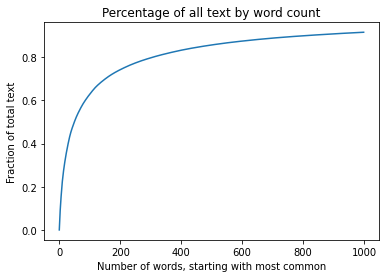

In [21]:
plt.figure()
plt.title('Percentage of all text by word count')
plt.plot(fraction_vs_num_words)
plt.xlabel('Number of words, starting with most common')
plt.ylabel('Fraction of total text')
plt.show()

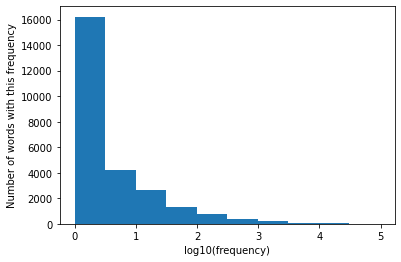

In [22]:
plt.figure()
plt.hist(np.log10(list(countdict.values())), bins=10)
plt.xlabel('log10(frequency)')
plt.ylabel('Number of words with this frequency')
plt.show()

In [23]:
gensim_corpus = [many_whitespace_to_one(conv).split() for topic in corpus_text for conv in topic]

Finally, can write this to a file to save and not have to repeat calculations

In [24]:
from gensim.test.utils import common_texts
from gensim.models import Word2Vec, Doc2Vec
model = Word2Vec(sentences=common_texts, size=100, window=5, min_count=1, workers=4)

Already a fork in the road; can choose to load in the utterances (sentence) individually or by conversation (i.e. paragraph == sentence). For a high level approach I think the latter is more viable, but this requires reading.

#### Reason 1: Preliminary investigation is a coarse grained approach to test viability.
Only trying to guess the topic, of which there are 7. 

#### Reason 2: short utterances
I still need to read up on word embeddings; I know they are not one-hot encodings, but if they have similar properties then
due to the curse of dimensionality, embeddings of 1 word utterances will be very far from median distance even if they correspond to high frequency words. I am imagining a vector with only 1 non-zero entry, but if word2vec chooses a smart basis
this won't be the case. 

#### Reason 3: Performance?
I do not know how performance scales with length of sentences vs. number of sentences, again this comes down to the individual
algorithms. 